# Install

## Install Package to write CAS XMI files
See https://github.com/dkpro/dkpro-cassis

In [1]:
pip install numpy dkpro-cassis "scikit-learn==0.23.1" datasets transformers[torch] ipywidgets matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, HTML

# Import Project Data

## Load CAS

In [3]:
from cassis import *

with open('./data/TypeSystem.xml', 'rb') as f:
    typesystem = load_typesystem(f)

cas = []

# Random Dataset    
with open('./data/random.xmi', 'rb') as f:
    cas.append(load_cas_from_xmi(f, typesystem=typesystem))

# Random Categories Dataset    
with open('./data/random_categories.xmi', 'rb') as f:
    cas.append(load_cas_from_xmi(f, typesystem=typesystem))

# NSP Dataset    
with open('./data/nsp.xmi', 'rb') as f:
    cas.append(load_cas_from_xmi(f, typesystem=typesystem))

# NSP Categories Dataset    
with open('./data/nsp_categories.xmi', 'rb') as f:
    cas.append(load_cas_from_xmi(f, typesystem=typesystem))

# NSP Categories Dataset    03.06.
with open('./data/nsp_categories_3_6.xmi', 'rb') as f:
    cas.append(load_cas_from_xmi(f, typesystem=typesystem))

# Similarity Dataset    
with open('./data/similarity.xmi', 'rb') as f:
    cas.append(load_cas_from_xmi(f, typesystem=typesystem))

# Similarity Categories Dataset    
with open('./data/similarity_categories.xmi', 'rb') as f:
    cas.append(load_cas_from_xmi(f, typesystem=typesystem))

# Similarity Categories Dataset 03.06.    
with open('./data/similarity_categories_3_6.xmi', 'rb') as f:
    cas.append(load_cas_from_xmi(f, typesystem=typesystem))

# Similarity Categories Dataset 10.06.    
with open('./data/similarity_categories_10_6.xmi', 'rb') as f:
    cas.append(load_cas_from_xmi(f, typesystem=typesystem))

# Similarity Categories Dataset 11.06.    
with open('./data/similarity_categories_11_6.xmi', 'rb') as f:
    cas.append(load_cas_from_xmi(f, typesystem=typesystem))


## Get Labels

In [4]:
# Without Translation (not used)
labels = ["none", "attribution", "causal", "conditional", "contrast", "description", "equivalence", "fulfillment", "identity", "purpose", "summary", "temporal"]
labels_subset = ["none", "causal", "contrast", "equivalence", "identity", "temporal", "others"]
def index_of_label(val):
    global labels_subset
    try:
        return labels_subset.index(val)
    except ValueError:
        return len(labels_subset) - 1

## Get Annotations

### Set annotation Preference
- Set whether to include news article headings or not
- If news headings are included, define separator (heading1 + separator + sentence1)
- Set whether to include timestamp of article
- If timestamp is used, define separator

In [5]:
annotation_with_news_title = True
annotation_title_separator = ". "
annotation_with_timestamp = True
annotation_timestamp_separator = " "

### Get Additional Doc Meta data (timestamp)

In [6]:
if annotation_with_timestamp:
    doc_df = pd.read_csv("./malte-candidates/meta-output.docs.tsv", sep="\t")
    doc_df = doc_df.set_index("doc_id")
    display(doc_df)

,url,title,categories,timestamp
doc_id,,,,
736,https://en.wikinews.org/wiki?curid=736,President of China lunches with Brazilian Pres...,"Politics and conflicts,South America,Asia,Braz...","November 12, 2004"
741,https://en.wikinews.org/wiki?curid=741,Palestinians to elect new president on January 9,"Palestine,Elections,Mahmoud Abbas,Yasser Arafa...","November 14, 2004"
743,https://en.wikinews.org/wiki?curid=743,Brazilian delegation returns from Arafat funeral,"Palestine,Brazil,Politics and conflicts,Middle...","November 13, 2004"
764,https://en.wikinews.org/wiki?curid=764,Hearing begins over David Hookes death,"Australia,Cricket,Crime and law,Oceania","November 15, 2004"
797,https://en.wikinews.org/wiki?curid=797,Brazilian soccer player's mother has been kidn...,"South America,Brazil,Football (soccer),Crime a...","November 15, 2004"
...,...,...,...,...
2909791,https://en.wikinews.org/wiki?curid=2909791,"Mohsen Fakhrizadeh, leader of Iranian nuclear ...","Iran,Asia,Middle East,Nuclear technology,Obitu...",2020-11-30T21:59:34Z
2909805,https://en.wikinews.org/wiki?curid=2909805,Former US national security advisor Michael Fl...,"United States,North America,Crime and law,Poli...",2020-11-28T22:49:40Z
2909818,https://en.wikinews.org/wiki?curid=2909818,"Wikinews interviews Sandra Jephcott, Sustainab...","Australia,Elections,Climate change,COVID-19,Qu...",2020-11-27T15:33:59Z


In [7]:
#doc_df.loc[741]

In [8]:
def get_timestamp_from_doc(doc_id):
    global doc_df
    try: 
        item = doc_df.loc[int(doc_id)]
        return item.timestamp
    except (TypeError, ValueError, KeyError) as e:
        print(f"Cannot find Doc #{doc_id}: {e}")
        return ""

### Read Annotations

In [9]:
total_number_pairs = 0
label_count = [0] * len(labels_subset)
# Random, NSP, Similarity
pair_matching_count = [0, 0, 0]

def read_annotations(tmp_cas, controlPairList = []):
    global labels, labels_subset, annotation_with_news_title, annotation_title_separator, annotation_with_timestamp, annotation_timestamp_separator
    origin = []
    target = []
    label = []
    for sentence in tmp_cas.select('webanno.custom.Sentence'):
        for token in tmp_cas.select_covered('webanno.custom.SentenceRelation', sentence):
            # Only use annotated data
            if token.label != "unset":
                # Check for redundant pairs
                uid = f"g{token.Governor.sent_id}_d_{token.Dependent.sent_id}"
                if uid not in controlPairList:
                    origin_string = ""
                    target_string = ""
                    label.append(index_of_label(token.label))
                    # Also add meta data: title
                    if annotation_with_news_title:
                        origin_string += token.Governor.get_covered_text() + annotation_title_separator
                        target_string += token.Dependent.get_covered_text() + annotation_title_separator
                    # Add Sentences
                    origin_string += token.Governor.title
                    target_string += token.Dependent.title
                    # Also add meta data: timestamp
                    if annotation_with_timestamp:
                        origin_string += annotation_timestamp_separator + get_timestamp_from_doc(token.Governor.doc_id)
                        target_string += annotation_timestamp_separator + get_timestamp_from_doc(token.Dependent.doc_id)
                    # Add String to list
                    origin.append(origin_string)
                    target.append(target_string)
                    controlPairList.append(uid)
                    #print('Dependent: ' + token.Dependent.get_*covered_text())
                    #print('Governor: ' + token.Governor.get_covered_text())
                    #print('Label: ' + token.label)
                    #print('')
    return origin, target, label, controlPairList


## Combine CAS Systems

In [10]:
def combined_cas_read(cas_list):
    global pair_matching_count
    origin = []
    target = []
    label = []
    count = 0
    # control list of pairs to not add redundant pairs
    controlPairList = []
    for cas in cas_list:
        count += 1
        origin_tmp, target_tmp, label_tmp, controlPairList_tmp = read_annotations(cas, controlPairList)
        # Count Statistics
        if(count <= 2):
            pair_matching_count[0] += len(label_tmp)
        elif(count <= 5):
            pair_matching_count[1] += len(label_tmp)
        else:
            pair_matching_count[2] += len(label_tmp)
        origin += origin_tmp
        target += target_tmp
        label += label_tmp
        controlPairList += controlPairList_tmp
    return origin, target, label

origin, target, label = combined_cas_read(cas)
total_number_pairs = len(label)


## Split / K-Fold

### Set Random Seeds for reproducability

In [11]:
def set_seed(seed_number: int):
    global seed
    seed = seed_number
    np.random.seed(seed_number)
    torch.manual_seed(seed_number)
    torch.cuda.manual_seed_all(seed_number)

set_seed(122)

### k-Fold Split with same distribution

In [12]:
from sklearn.model_selection import StratifiedKFold, train_test_split

# o: origin, t: target, l: label list
def k_fold_train_test_split(o, t, l, random_state=None):
    skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=random_state)
    # Empty dataset (not needed)
    empty_X = np.zeros(len(l))
    skf.get_n_splits(empty_X, l)
    origin_array = np.array(o)
    target_array = np.array(t)
    label_array = np.array(l)
    # Store all k-folds
    k_fold_origin = []
    k_fold_target = []
    k_fold_labels = []
    for train_index, test_index in skf.split(empty_X, l):
        #print("TRAIN:", train_index, "TEST:", test_index)
        train_origin, test_origin = origin_array[train_index], origin_array[test_index]
        train_target, test_target = target_array[train_index], target_array[test_index]
        train_labels, test_labels = label_array[train_index], label_array[test_index]
        k_fold_origin.append([train_origin.tolist(), test_origin.tolist()])
        k_fold_target.append([train_target.tolist(), test_target.tolist()])
        k_fold_labels.append([train_labels.tolist(), test_labels.tolist()])
    return k_fold_origin, k_fold_target, k_fold_labels

#train_origin, test_origin, train_target, test_target, train_labels, test_labels = train_test_split(origin, target, label,random_state=seed, stratify=label)

#tmp_train_origin, val_origin, tmp_train_target, val_target, tmp_train_labels, val_labels = train_test_split(origin, target, label, random_state=seed)
#train_origin, test_origin, train_target, test_target, train_labels, test_labels = train_test_split(tmp_train_origin, tmp_train_target, tmp_train_labels,random_state=seed)
k_fold_origin, k_fold_target, k_fold_labels = k_fold_train_test_split(origin, target, label,random_state=seed)

## Print Examples

In [13]:
#train_encodings

In [14]:
def show_random_elements(origin_list, target_list, label_list, num_examples=10):
    global labels_subset
    assert num_examples <= len(origin_list), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(origin_list)-1)
        while pick in picks:
            pick = random.randint(0, len(origin_list)-1)
        picks.append(pick)
    data = []
    for n in picks:
        data.append([n, origin_list[n], labels_subset[label_list[n]], target_list[n]])
    df = pd.DataFrame(data, columns=['index', 'Origin', 'Label', 'Target'])
    display(HTML(df.to_html()))

In [15]:
# show_random_elements(train_origin, train_target, train_labels, train_encodings)
# Output adjustet to Folds
show_random_elements(k_fold_origin[0][0], k_fold_target[0][0], k_fold_labels[0][0])

,index,Origin,Label,Target
0,1474,"The Haaretz had initially reported that former prime minister Mahmoud Abbas was selected by the Fatah central committee as their candidate for president, but Abbas has denied this, saying, the matter is still being discussed.. Palestinians to elect new president on January 9 November 14, 2004",none,"He said he would be heading home to Gaza later in the day, but once the border crossing is officially reopened, he wants to return to Egypt legally, allowing him freedom of movement.. Egypt seals border with Gaza after 11 days February 3, 2008"
1,2747,"The two officers were responding to a call at about 9:00 p.m. on December 5, that a male and female were fighting inside a Valero gas station located on West Chippewa and Elmwood Avenues in Downtown Buffalo when one of the suspects, Varner Harris, 18 and lives in Buffalo, fled police.. Injured Buffalo, New York police officer returns home December 8, 2006",none,"According to Buffalo Fire Department radio communications, at least 12 people were injured after a van carrying a church group flipped over on an expressway interchange in Buffalo, New York.. 12 injured after van carrying church group flips over on Buffalo, NY expressway August 17, 2009"
2,2232,"According to officials, almost a hundred people suspected to be insurgents were killed in northwestern Pakistan early on Saturday by air strikes conducted by the military.. Officials: Almost 100 killed in air raids in Pakistan April 10, 2010",none,"According to official reports corroborated by Pakistani President General Pervez Musharraf, the blast was set off as the victims were making explosives inside a suspected al-Qaeda hideout.. Top al-Qaeda leader killed in Pakistan December 3, 2005"
3,533,"The ANSTO report found nuclear plants could be built in the next 10 to 15 years and an Australian version would cost about $2.5 billion to establish.. Australian nuclear power plants rejected by states June 05, 2006",none,"Justice Haynes said that the definitions in the constitution need to be read in context of the 1890s, which were boom and bust times for corporations in Australia.. States challenge to Australian Work Choices Act begins December 22, 2006"
4,2433,"President Josefa Iloilo abrogated the country's constitution and declared himself head of state in response to a court ruling that the military regime was unlawful.. Journalists deported from Fiji April 10, 2009",others,"Fiji's Court of Appeal has ruled that the removal of Prime Minister Laisenia Qarase and the appointment of Fiji's interim regime following the military coup in 2006 was unlawful.. Fiji court rules interim regime unlawful April 9, 2009"
5,3080,"Since attacks by separatists in Thailand's Malay Muslim-majority provinces flared up in January 2004, there are have about 2,000 people killed in bombings and almost-daily drive-by shootings.. Police officer killed, at least 18 injured in south Thailand blasts July 17, 2007",causal,"On Sunday, 12 people were injured and one killed in a series of bombings in the city of Hat Yai. The next day, four people were killed when a bomb-laden motorcycle exploded at a crowded market in Saba Yoi. Six men were arrested on Thursday in connection with Sunday's bombings.. 21 dead in south Thailand attacks May 29, 2007"
6,404,"There has never been any threat of violence against Housespideranon or any other member of Anonymous made by me, Schaper told Wikinews.. Alleged 'rights group' tries to have 4,000 anti-Scientology videos removed from YouTube April 18, 2008",none,"The company responsible for making the porno film is Van Nuys, California-based Shane's World.. California State University, Chico fraternity suspended for making frat house porno flick March 29, 2005"
7,854,"Although it welcomed the news of disarmament, the Commission said it was concerned by the UVF's intention to deal with their arms without the involvement of the IICD.. Ulster Volunteer Force announces it will put weapons ""beyond reach""

## Print Statistics

In [16]:
distribution_count = [0] * len(labels_subset)
def get_label_statistics(label_list):
    global labels_subset, distribution_count
    count = [0] * len(labels_subset)
    total = 0
    # total numbers
    for l in label_list:
        total = total + 1
        count[l] = count[l] + 1
        distribution_count[l] += 1
    # display percentages
    if total > 0:
        for i in range(len(count)):
            count[i] = str(count[i]) + " (" + str(round(count[i] * 100 / total, 2)) + "%)"
    return count



### Number of Pairs & Matchings

In [17]:
pair_matching_count.append(total_number_pairs)
df_matching = pd.DataFrame([pair_matching_count], columns=["Random", "NSP", "Similarity", "Total"])
display(df_matching)

,Random,NSP,Similarity,Total
0,1232,1058,2712,5002


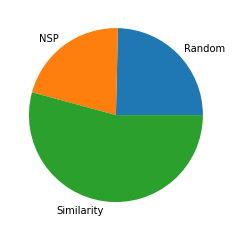

In [18]:
plt.pie(np.array(pair_matching_count[:-1]), labels = ["Random", "NSP", "Similarity"])
plt.savefig('data/export-subset/pairs_matching.png', dpi=300)
plt.show() 

### Label Distribution

In [19]:
df_distribution = pd.DataFrame([get_label_statistics(label)], columns=labels_subset)
display(df_distribution)


,none,causal,contrast,equivalence,identity,temporal,others
0,3172 (63.41%),434 (8.68%),165 (3.3%),340 (6.8%),80 (1.6%),590 (11.8%),221 (4.42%)


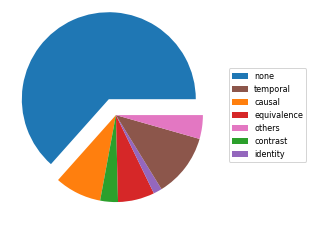

In [20]:
myexplode = [0] * len(labels_subset)
myexplode[0] = 0.2
patches, texts = plt.pie(np.array(distribution_count), explode = myexplode)
# Sort Labels
patches, labels, dummy =  zip(*sorted(zip(patches, labels_subset, np.array(distribution_count)),key=lambda x: x[2],reverse=True))
plt.legend(patches, labels, loc='center left', bbox_to_anchor=(1., 0.5),fontsize=8)
plt.savefig('data/export-subset/pairs_distribution.png', dpi=300)
plt.show() 

# Write Folds to disk

In [21]:
export_path = "data/export-subset/"

In [22]:
def create_df(origin, target, label):
    return pd.DataFrame(list(zip(origin, target, label)), columns=['origin', 'target', 'label'])

def export_dfs(k_fold_origin, k_fold_target, k_fold_labels):
    global export_path
    for i in range(len(k_fold_origin)):
        train_df = create_df(k_fold_origin[i][0], k_fold_target[i][0], k_fold_labels[i][0])
        test_df = create_df(k_fold_origin[i][1], k_fold_target[i][1], k_fold_labels[i][1])
        train_df.to_csv(f'{export_path}train.{i}.csv', index=False)
        test_df.to_csv(f'{export_path}test.{i}.csv', index=False)

In [23]:
export_dfs(k_fold_origin, k_fold_target, k_fold_labels)